In [1]:
!pip install -q segmentation-models-pytorch albumentations torchmetrics pytorch-lightning clearml python-dotenv gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.0 MB/s eta 0:00:00


In [2]:
import os
import math
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from torch.utils.data import DataLoader, Dataset
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2
from clearml import Task
import cv2
import numpy as np
from google.colab import files
from dotenv import load_dotenv
import gdown
import zipfile
from concurrent.futures import ProcessPoolExecutor

In [3]:
from google.colab import userdata, drive

os.environ['CLEARML_API_ACCESS_KEY'] = userdata.get('CLEARML_API_ACCESS_KEY')
os.environ['CLEARML_API_SECRET_KEY'] = userdata.get('CLEARML_API_SECRET_KEY')

In [4]:
drive.mount('/content/drive')


source_path = '/content/drive/MyDrive/'

tasks = [
    {
        "files": ["leftImg8bit_trainvaltest.zip", "gtFine_trainvaltest.zip"],
        "dest": "/content/data/cityscapes/"
    }
]

for task in tasks:
    if not os.path.exists(task["dest"]):
        os.makedirs(task["dest"])

    for zip_file in task["files"]:
        full_path = os.path.join(source_path, zip_file)

        if os.path.exists(full_path):
            print(f"Unpacking {zip_file} in {task['dest']}...")
            !unzip -q -o "{full_path}" -d "{task['dest']}"
        else:
            print(f"Error, file not found: {full_path}")

Mounted at /content/drive
Unpacking leftImg8bit_trainvaltest.zip in /content/data/cityscapes/...
Unpacking gtFine_trainvaltest.zip in /content/data/cityscapes/...


In [5]:
CONFIG = {
    "project_name": "Segmentation_Urban_Scene_CourseWork",
    "task_name": "DeepLabV3+_Baseline_Cityscapes_Poly_SGD_Standard_ResizeV2",
    "data_dir": "./data/cityscapes",
    "encoder": "resnet50",
    "encoder_weights": "imagenet",
    "classes": 19,
    "batch_size": 16,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "epochs": 50,
    "image_size": (512, 1024),
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

task = Task.init(
    project_name=CONFIG["project_name"],
    task_name=CONFIG["task_name"],
    output_uri=False
)
task.connect(CONFIG)

ClearML Task: created new task id=f2f58abe798948d4808352ecf004de86


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


ClearML results page: https://app.clear.ml/projects/588d5d925230490b9f98b1007b4c7fa0/experiments/f2f58abe798948d4808352ecf004de86/output/log


{'project_name': 'Segmentation_Urban_Scene_CourseWork',
 'task_name': 'DeepLabV3+_Baseline_Cityscapes_Poly_SGD_Standard_ResizeV2',
 'data_dir': './data/cityscapes',
 'encoder': 'resnet50',
 'encoder_weights': 'imagenet',
 'classes': 19,
 'batch_size': 16,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'epochs': 50,
 'image_size': (512, 1024),
 'device': 'cuda'}

In [6]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root_dir, 'gtFine', split)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.ids = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            mask_dir = os.path.join(self.masks_dir, city)
            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                   self.ids.append({
                       'image': os.path.join(img_dir, file_name),
                       'mask': os.path.join(mask_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png'))
                   })

        self.mapping = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9,
            23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        sample = self.ids[i]
        image = cv2.imread(sample['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask'], 0)

        mask_mapped = np.ones_like(mask) * 255
        for k, v in self.mapping.items():
            mask_mapped[mask == k] = v
        mask = mask_mapped

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.long()

In [7]:
def _to_float32(image, **kwargs):
    return image.astype(np.float32)


class RoadDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, image_size, encoder, encoder_weights):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

    def setup(self, stage=None):
        self.train_transform = A.Compose([
            A.Resize(height=self.image_size[0], width=self.image_size[1]),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, p=0.5),
        ])

        self.valid_transform = A.Compose([
            A.Resize(height=self.image_size[0], width=self.image_size[1]),
        ])

        self.preprocessing = A.Compose([
            A.Lambda(image=self.preprocessing_fn),
            A.Lambda(image=_to_float32),
            A.pytorch.ToTensorV2()
        ])

        self.train_ds = CityscapesDataset(self.data_dir, split='train', augmentation=self.train_transform, preprocessing=self.preprocessing)
        self.val_ds = CityscapesDataset(self.data_dir, split='val', augmentation=self.valid_transform, preprocessing=self.preprocessing)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
class ClearMLMetricsCallback(Callback):
    def __init__(self, task):
        super().__init__()
        self._logger = task.get_logger()

    def _log_metrics(self, trainer, stage):
        for name, value in trainer.callback_metrics.items():
            if isinstance(value, torch.Tensor):
                value = value.detach().cpu().item()
            if isinstance(value, (int, float)) and math.isfinite(value):
                self._logger.report_scalar(stage, name, value, iteration=trainer.current_epoch)

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")


class RoadModel(pl.LightningModule):
    def __init__(self, arch, encoder, encoder_weights, in_channels, out_classes, lr=1e-2, momentum=0.9, weight_decay=1e-4, epochs=1):
        super().__init__()
        self.save_hyperparameters()

        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=out_classes,
        )

        self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

        self.train_miou = JaccardIndex(task="multiclass", num_classes=out_classes, ignore_index=255)
        self.val_miou = JaccardIndex(task="multiclass", num_classes=out_classes, ignore_index=255)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)

        loss = self.loss_fn(logits, masks)

        preds = torch.argmax(logits, dim=1)
        self.train_miou(preds, masks)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_miou", self.train_miou, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = self.loss_fn(logits, masks)

        preds = torch.argmax(logits, dim=1)
        self.val_miou(preds, masks)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_miou", self.val_miou, on_epoch=True, prog_bar=True, logger=True)

        if batch_idx == 0:
            experiment = getattr(self.logger, "experiment", None)
            if experiment is not None and hasattr(experiment, "report_image"):
                experiment.report_image(
                    "Validation Prediction",
                    "Image_0",
                    iteration=self.current_epoch,
                    image=preds[0].float().cpu().numpy() / 19.0 * 255
                )

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=self.hparams.momentum,
            weight_decay=self.hparams.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.PolynomialLR(
            optimizer,
            total_iters=self.hparams.epochs,
            power=0.9
        )
        return [optimizer], [scheduler]

In [ ]:
dm = RoadDataModule(
    CONFIG["data_dir"],
    CONFIG["batch_size"],
    CONFIG["image_size"],
    CONFIG["encoder"],
    CONFIG["encoder_weights"]
)

model = RoadModel(
    arch="deeplabv3plus",
    encoder=CONFIG["encoder"],
    encoder_weights=CONFIG["encoder_weights"],
    in_channels=3,
    out_classes=CONFIG["classes"],
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"],
    epochs=CONFIG["epochs"]
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_miou",
    dirpath="./checkpoints",
    filename="deeplab-cityscapes-{epoch:02d}-{val_miou:.2f}",
    save_top_k=1,
    mode="max",
)

trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="gpu",
    devices=1,
    logger=True,
    callbacks=[
        checkpoint_callback,
        TQDMProgressBar(refresh_rate=20),
        ClearMLMetricsCallback(task)
    ],
    precision="16-mixed",
)

trainer.fit(model, datamodule=dm)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning:

ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: UserWarning:

Precision 16-mixed is not supported by the model summary.  Estimated model size in MB 

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ DeepLabV3Plus          │ 26.7 M │ train │     0 │
│ 1 │ loss_fn    │ CrossEntropyLoss       │      0 │ train │     0 │
│ 2 │ train_miou │ MulticlassJaccardIndex │      0 │ train │     0 │
│ 3 │ val_miou   │ MulticlassJaccardIndex │      0 │ train │     0 │
└───┴────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 26.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.7 M                                                                                               
Total estimated model params size (MB): 106                                                                        
Modules in train mode: 210                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.1896936595439911     │
│         val_miou          │    0.6622208952903748     │
└───────────────────────────┴───────────────────────────┘


Results:



,Metric,Value
0,Loss,0.1897
1,mIoU,0.6622
2,Percent,66.22%


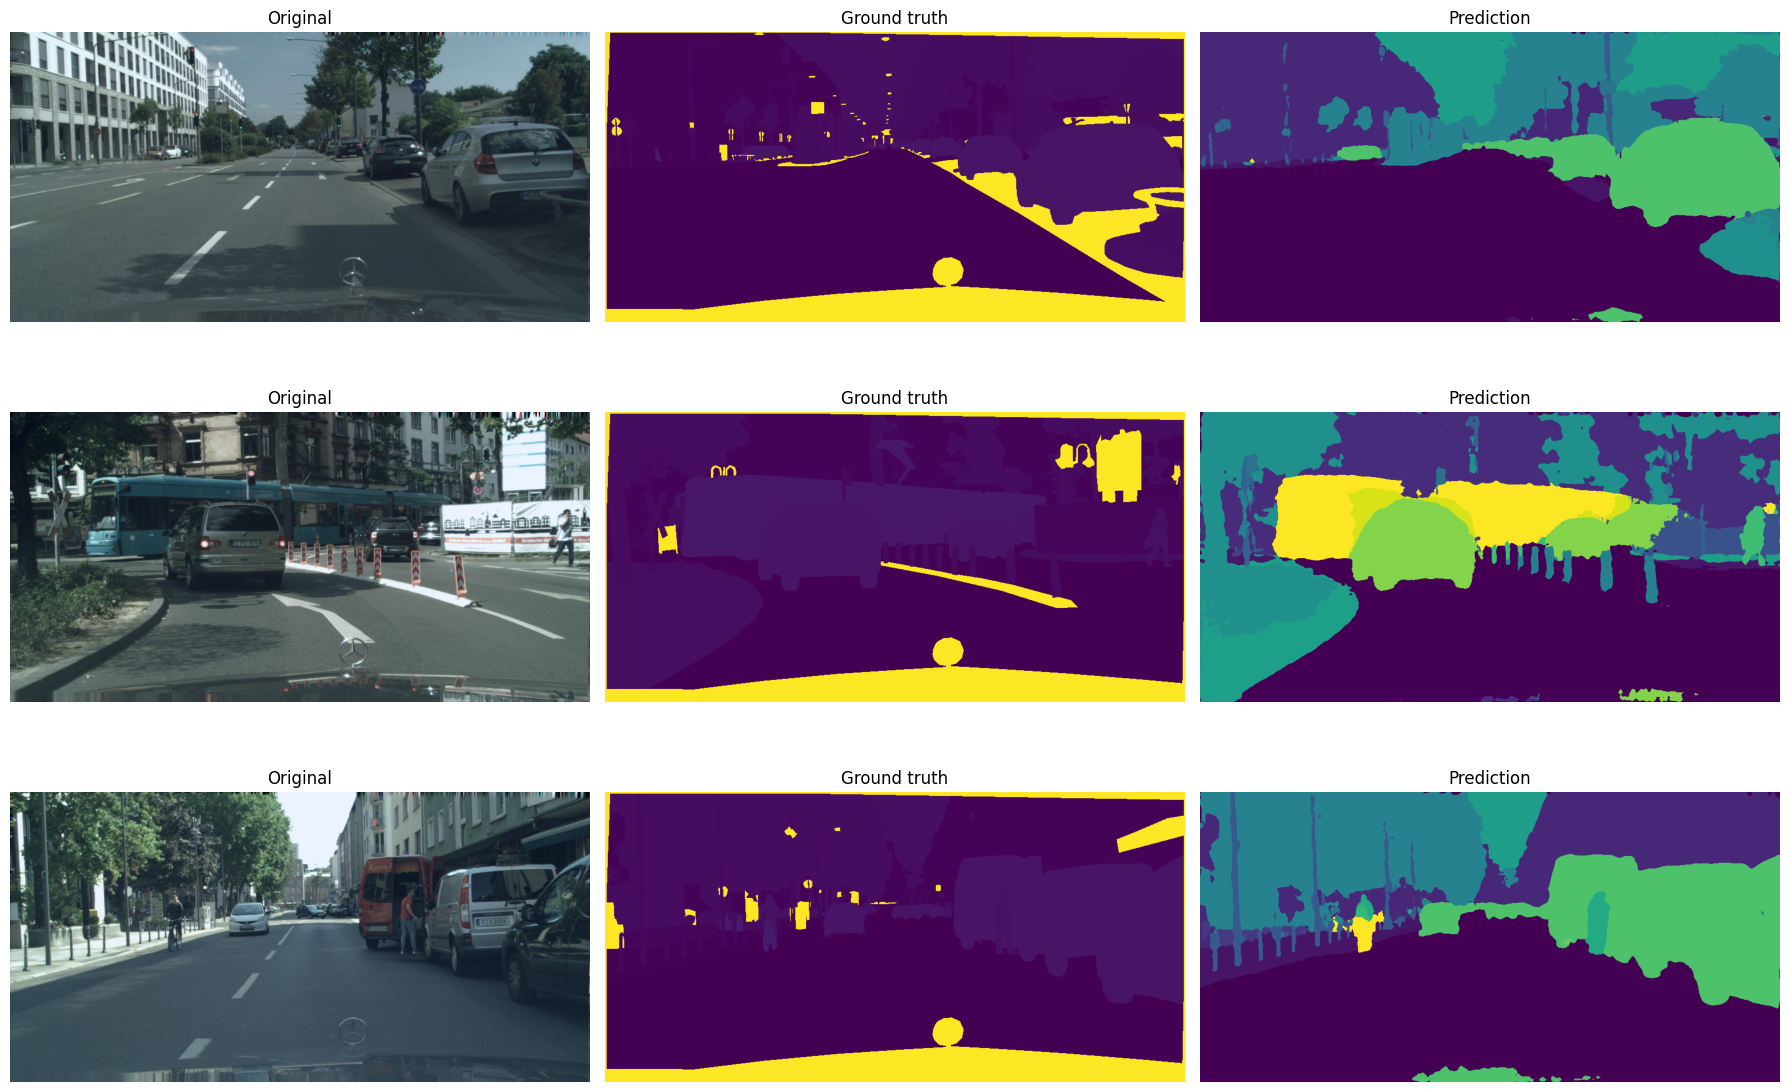

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path

best_model = RoadModel.load_from_checkpoint(best_model_path)
best_model.to(CONFIG["device"])
best_model.eval()


val_results = trainer.validate(best_model, datamodule=dm)[0]

metrics_data = {
    "Metric": ["Loss", "mIoU", "Percent"],
    "Value": [
        f"{val_results['val_loss']:.4f}",
        f"{val_results['val_miou']:.4f}",
        f"{val_results['val_miou']*100:.2f}%"
    ]
}
df = pd.DataFrame(metrics_data)

print("\n" + "="*30)
print("Results:" + "\n")
print("="*30)
display(df)

def visualize_predictions(model, datamodule, num_samples=3):
    model.to(CONFIG["device"])
    model.eval()

    val_loader = datamodule.val_dataloader()
    images, masks = next(iter(val_loader))

    images = images.to(CONFIG["device"])
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(18, num_samples * 4))

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i])
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i])
        plt.title(f"Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, dm)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path

model_name = os.path.basename(best_model_path)

current_task = Task.get_task(task_id=task.id)

current_task.update_output_model(
    model_path=best_model_path,
    model_name=model_name,
    iteration=trainer.current_epoch
)

'https://files.clear.ml/Segmentation_Urban_Scene_CourseWork/DeepLabV3+_Baseline_Cityscapes_Poly_SGD_Standard_ResizeV2.f2f58abe798948d4808352ecf004de86/models/deeplab-cityscapes-epoch=47-val_miou=0.66.ckpt'

In [ ]:
task.close()